In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
import datetime as datetime

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
sys.path.append('/home/sachin/miniconda3/envs/server_env')
sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
#REPPU otuputs
#path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pwbig5min.dat'#Mac
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/wbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [3]:
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])
mhd_data

,start,end,total_days
0,2021/05/10,2021/05/14,5
1,2021/05/31,2021/06/03,4
2,2021/07/26,2021/07/29,4
3,2021/09/09,2021/09/12,4
4,2021/10/11,2021/10/14,4
5,2021/11/01,2021/11/06,6
6,2021/11/25,2021/11/29,5
7,2022/01/30,2022/02/03,5
8,2022/03/11,2022/03/15,5
9,2022/03/28,2022/04/01,5


In [4]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'conductivity': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['conductivity'].attrs['units'] = 'S/m'
ds

<xarray.Dataset> Size: 440MB
Dimensions:       (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt            (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat           (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon           (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    conductivity  (dt, lat, lon) float32 440MB 1.517 1.517 1.517 ... 5.173 5.166

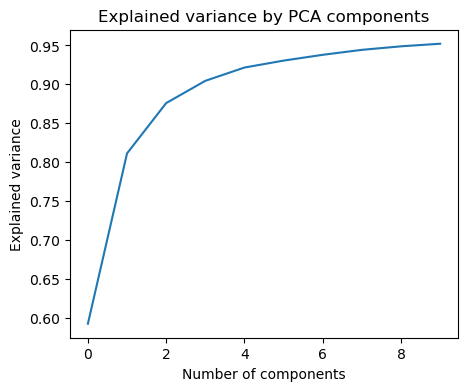

In [5]:
def create_PCA(ds, pca_comps, plot=False):

    ds = ds.copy()

    #reshape the data to be 2D
    ds_arr = ds['conductivity'].values
    ds_arr = ds_arr.reshape(ds_arr.shape[0], -1)

    #create PCA object with the number of components
    pca = PCA(n_components=pca_comps)
    pca.fit(ds_arr)

    #save the PCA object
    #with open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_conductivity_pca_ID5.pkl', 'wb') as f:
    #    pickle.dump(pca, f)
    pickle.dump(pca, open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_xy-conductivity_pca_ID5.pkl', 'wb'))

    reduced = pca.transform(ds_arr) #transform the data into the PCA space

    #return data to original space
    #inverse_transform = pca.inverse_transform(reduced)
    #print(inverse_transform.shape)

    if plot == True:
        # Plot the explained variance
        plt.figure(figsize=(5, 4))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of components')
        plt.ylabel('Explained variance')
        plt.title('Explained variance by PCA components')
        plt.show()

    ds_pca = xr.Dataset({'conductivity': (['dt', 'PC'], reduced)},
                        coords={'dt': ds['dt'], 'PC': np.arange(1, pca_comps+1)})

    return ds_pca, pca

pca_comps = 10
ds, pca = create_PCA(ds, pca_comps, plot=True)

In [6]:
#open the omni data and merge it with the REPPU data
#omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'
omni_mhd_path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/'

#omni_df = pd.read_csv('omni_mhd_5min.csv')
omni_df = pd.read_csv('omni_add-feats_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')

reppu_omni_ds = reppu_omni_ds.drop(['T', 'E', 'doy','BSN_x','SYM_H','F10.7','Kp','Mach_num'])
reppu_omni_ds = reppu_omni_ds.drop(['Pressure'])
#reppu_omni_ds = reppu_omni_ds.drop(['flow_speed','proton_density'])
reppu_omni_ds

/tmp/ipykernel_47233/3848750339.py:18: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  reppu_omni_ds = reppu_omni_ds.drop(['T', 'E', 'doy','BSN_x','SYM_H','F10.7','Kp','Mach_num'])
/tmp/ipykernel_47233/3848750339.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  reppu_omni_ds = reppu_omni_ds.drop(['Pressure'])


<xarray.Dataset> Size: 4MB
Dimensions:         (dt: 42158, PC: 10)
Coordinates:
  * dt              (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * PC              (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    conductivity    (dt, PC) float32 2MB 36.35 -34.02 -9.029 ... -2.674 -0.5267
    BY_GSE          (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 337kB 344.0 344.0 345.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 337kB 12.11 11.44 12.65 ... 8.03 7.08 6.84
    tilt_angle      (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2744 0.271

In [7]:
dates_to_remove = pd.date_range(start='2021-05-10 00:00:00', end='2021-05-10 23:55:00', freq='5min')
date_1_ds = reppu_omni_ds.where(reppu_omni_ds['dt'].isin(dates_to_remove), drop=True)
mask = ~reppu_omni_ds['dt'].isin(dates_to_remove)
date1 = reppu_omni_ds.where(mask, drop=True)

dates_to_remove2 = pd.date_range(start='2021-10-11 00:00:00', end='2021-10-11 23:55:00', freq='5min')
date_2_ds = date1.where(date1['dt'].isin(dates_to_remove2), drop=True)
mask2 = ~date1['dt'].isin(dates_to_remove2)
date2 = date1.where(mask2, drop=True)

dates_to_remove3 = pd.date_range(start='2022-01-30 00:00:00', end='2022-01-30 23:55:00', freq='5min')
date_3_ds = date2.where(date2['dt'].isin(dates_to_remove3), drop=True)
mask3 = ~date2['dt'].isin(dates_to_remove3)
reppu_omni_ds = date2.where(mask3, drop=True)
reppu_omni_ds

<xarray.Dataset> Size: 4MB
Dimensions:         (dt: 41303, PC: 10)
Coordinates:
  * dt              (dt) datetime64[ns] 330kB 2021-05-11 ... 2022-07-31T23:55:00
  * PC              (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    conductivity    (dt, PC) float32 2MB 0.9502 -69.85 -24.07 ... -2.674 -0.5267
    BY_GSE          (dt) float64 330kB 4.2 4.22 4.19 3.78 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 330kB -0.59 -0.7 -0.92 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 330kB 340.0 343.0 344.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 330kB 8.97 8.45 8.55 8.73 ... 8.03 7.08 6.84
    tilt_angle      (dt) float64 330kB 0.2575 0.2542 0.2509 ... 0.2744 0.271

In [8]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [9]:
#training
X_train = ds_train.drop_vars('conductivity').to_array().values.T #drop conductivity and keep the rest
y_train = ds_train['conductivity'].values

#testing
X_test = ds_test.drop_vars('conductivity').to_array().values.T #drop conductivity and keep the rest
y_test = ds_test['conductivity'].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36576, 5), (36576, 10), (4727, 5), (4727, 10))

In [10]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 450 #number of reservoir neurons
density = 0.2 #connection density
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-2 #regularization factor

In [11]:
model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=density, input_scale=input_scaling, rho=spectral_radius)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=beta)
model.train(X_train, y_train, optimizer)

array([[ 175.8067162 ,  305.04261119, -398.32383653, ..., -599.39910493,
        -577.2672885 , -180.408164  ],
       [ 180.14775422,  308.91590552, -406.24757252, ..., -606.59308946,
        -584.21282127, -182.28334811],
       [ 180.59710962,  310.14554503, -407.79117774, ..., -608.60041877,
        -585.96167531, -183.17417481],
       ...,
       [ 191.77928331,  340.87312117, -458.57350182, ..., -676.65109551,
        -655.80922515, -221.24683456],
       [ 188.09794988,  333.17182584, -448.75164135, ..., -663.84013395,
        -642.14035514, -216.53744207],
       [ 188.69594836,  334.07591985, -449.88156679, ..., -665.37116707,
        -643.95120175, -217.00509346]])

In [12]:
#save or load model
with open('/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_xy-cond_ID5.pkl', 'wb') as f:
    pickle.dump(model, f)

In [13]:
#make prediction on the test data
y_pred = model.predict(X_test)

#inverse transform the data / return to the original space
y_pred_orig = pca.inverse_transform(y_pred)
y_pred_orig = y_pred_orig.reshape(-1, 30, 80) #reshape the prediction to lat, lon
y_test_orig = pca.inverse_transform(y_test)
y_test_orig = y_test_orig.reshape(-1, 30, 80) #reshape the prediction to lat, lon

In [14]:
ds_test['cond_pred'] = (('dt', 'lat', 'lon'), y_pred_orig)
#ds_test['cond_pred'].attrs['units'] = 'mA/m^2'
ds_test['cond_test'] = (('dt', 'lat', 'lon'), y_test_orig)
#ds_test['cond_test'].attrs['units'] = 'mA/m^2'

#ds_test = ds_test.drop_vars('current')
#ds_test = ds_test.drop_dims('PC')

ds_test['err_abs'] = np.abs(ds_test['cond_pred'] - ds_test['cond_test'])
#ds_test['err'] = ds_test['current_pred'] - ds_test['current']
#ds_test['err_pct'] = ds_test['err'] / ds_test['current'] * 100
#ds_test['MLT'] = np.mod(ds_test['lon'] / 15, 24)
ds_test

<xarray.Dataset> Size: 227MB
Dimensions:         (dt: 4727, PC: 10, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 38kB 2022-07-14T21:10:00 ... 2022-07-...
  * PC              (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Dimensions without coordinates: lat, lon
Data variables:
    conductivity    (dt, PC) float32 189kB 251.9 41.61 -21.28 ... -2.674 -0.5267
    BY_GSE          (dt) float64 38kB 6.9 6.66 6.71 6.45 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 38kB -2.58 -2.45 -2.25 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 38kB 383.0 360.0 353.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 38kB 0.48 0.47 0.4 0.38 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 38kB 0.4447 0.4414 0.4381 ... 0.2744 0.271
    cond_pred       (dt, lat, lon) float64 91MB 1.516 1.516 ... 4.888 4.888
    cond_test       (dt, lat, lon) float32 45MB 1.516 1.516 1.516 ... 4.99 4.99
    err_abs         (dt, lat, lon) float64 91MB 5.884e-06 2.096e-06 ... 0.1012

In [ ]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

nan_count(ds_test, 'err_abs')

In [15]:
conductivity = ds_test['cond_test'].values
conductivity = conductivity.reshape(-1, 30, 80)

pred_cond = ds_test['cond_pred'].values
pred_cond = pred_cond.reshape(-1, 30, 80)

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill             

RMSE = np.sqrt(np.mean((conductivity - pred_cond)**2))
NRMSE = RMSE / (np.max(conductivity) - np.min(conductivity))
MAE = np.mean(np.abs(conductivity - pred_cond))
PE = skill(conductivity, pred_cond)
R = np.corrcoef(conductivity.flatten(), pred_cond.flatten())[0, 1]

print(f'RMSE: {RMSE:.1f} S/m')
print(f'NRMSE: {NRMSE:.2f}/1')
print(f'MAE: {MAE:.1f} S/m')
print(f'R: {R:.2f}/1')
print(f'PE: {PE:.2f}/1')

RMSE: 1.5 S/m
NRMSE: 0.04/1
MAE: 0.9 S/m
R: 0.84/1
PE: 0.53/1


In [ ]:
# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .4

# Plot true values
abs_error = np.abs(ds_test['err_abs'].mean('dt').values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 5, 40), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 2.1 (ESN) \nAbsolute Error, ID4')
plt.colorbar(c_true, ax=ax, label=' X Conductivity (Error) [S/m]', shrink=shrink, pad=0.15, ticks=np.arange(0,6,1), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)
plt.tight_layout()
plt.savefig('SMRAI_XY-cond_ID4.png', dpi=400)

Daily Predictions

In [ ]:
def daily_prediction(ds):

    ds  = ds.copy()

    prediction = model.predict(ds.drop_vars('conductivity').to_array().values.T)
    prediction = pca.inverse_transform(prediction)
    prediction = prediction.reshape(-1, 30, 80)

    ds['cond_pred'] = (('dt', 'lat', 'lon'), prediction)
    cond_test = ds['conductivity'].values
    cond_test = pca.inverse_transform(cond_test)
    cond_test = cond_test.reshape(-1, 30, 80)
    ds['cond_test'] = (('dt', 'lat', 'lon'), cond_test)

    ds = ds.drop_vars('conductivity')
    ds = ds.drop_dims('PC')

    return ds

daily_esn = daily_prediction(date_3_ds)
daily_esn

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

daily_esn['cond_test'].mean(['lat','lon']).plot()
daily_esn['cond_pred'].mean(['lat','lon']).plot()
plt.ylabel('Conductivity [S/m]')
plt.title('Daily Prediction')
plt.legend(['True', 'Predicted'])

In [ ]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-14 is worst
#2022-07-15 is worst

#2022-07-22 is good
#2022-07-23 is good
#2022-07-28 is good
#2022-07-30 is good

#2022-07-24 is best
#2022-07-29 is best
date = '2022-07-24'
fig, ax = plt.subplots(figsize=(7, 3))
ds_test['cond_test'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (ESN)')
ds_test['cond_pred'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (MHD)')

rmse = np.sqrt(np.mean((ds_test['cond_test'].sel(dt=date).values - ds_test['cond_pred'].sel(dt=date).values)**2))
plt.annotate(f'RMSE = {rmse:.2f} S/m', xy=(0.77, 0.1), xycoords='axes fraction')

plt.legend()
plt.title(f'Conductivity on {date}', pad=10)
plt.xlabel('MM-DD HH')
phi = r'$\phi$'
plt.ylabel(f'Conductivity [S/m]')
plt.grid(True, linestyle='--', alpha=0.5)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ds_pred['conductivity'].mean(['lat', 'lon']).plot(label='SMRAI2 (ESN)')
ds_test['conductivity'].mean(['lat', 'lon']).plot(label='REPPU (MHD)')

rmse = np.sqrt(np.mean((ds_pred['conductivity'].values - ds_test['conductivity'].values)**2))
nrmse = rmse / np.mean(ds_test['conductivity'].values)
R = np.corrcoef(ds_pred['conductivity'].values.flatten(), ds_test['conductivity'].values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  
PE = skill(ds_pred['conductivity'].values, ds_test['conductivity'].values)

plt.annotate(f'RMSE = {rmse:.2f} s\M', xy=(0.02, 0.9), xycoords='axes fraction')
plt.annotate(f'NMSE = {nrmse:.2f}', xy=(0.02, 0.8), xycoords='axes fraction')
plt.annotate(f'R = {R:.2f}', xy=(0.2, 0.9), xycoords='axes fraction')
plt.annotate(f'PE = {PE:.2f}', xy=(0.2, 0.8), xycoords='axes fraction')

plt.legend()
plt.title(f'Conductivity xx on test set', pad=10)
plt.xlabel(' ')
phi = r'$\phi$'
plt.ylabel(f'Conductivity [S/m]')
plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
err_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['conductivity'].sel(dt=date).values - ds_test['conductivity'].sel(dt=date).values)**2))
    nmse = rmse / np.std(ds_test['conductivity'].sel(dt=date).values)
    err_list.append([rmse, nmse])

err_df = pd.DataFrame(err_list, columns=['RMSE', 'NRMSE'])
err_df['dt'] = ds_test['dt']
err_df['date'] = err_df['dt'].dt.date
err_df['hr'] = err_df['dt'].dt.hour
err_df

In [ ]:
err_df.groupby('date').mean().sort_values(by='NRMSE', ascending=True)

In [ ]:
#plot the RMSE
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=err_df, x='date', y='RMSE', ax=ax)
plt.ylabel('RMSE [S/m]')
#plt.xticks(np.arange(0, 25, 3))
#plt.xlabel('UTC')

In [ ]:
#print unique dates from ds_pred dt
dates = ds_pred['dt'].dt.strftime('%Y-%m-%d').values
unique_dates = np.unique(dates)
unique_dates

In [ ]:
date = '2022-07-31'

In [ ]:
# Define the date
date = "2022-07-20"

# Extract true and predicted values
cond_true = ds_test['cond_test'].sel(dt=date).values[0]
cond_pred = ds_test['cond_pred'].sel(dt=date).values[0]

# Calculate the difference
diff = cond_true - cond_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, cond_true, levels=np.arange(0, 15, 1), cmap='viridis', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 16, 5), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, cond_pred, levels=np.arange(0, 15, 1), cmap='viridis', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 16, 5), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-8, 8, 30), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(-8, 9, 2), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


In [ ]:

# Select the date
date = "2022-07-29"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.13
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['cond_test'].sel(dt=date).values[i]
    pot_pred = ds_test['cond_pred'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Define common parameters
    theta = np.linspace(0, 360, 80) - 90
    theta_rad = theta / 360 * 2 * np.pi
    r = 90 - np.linspace(53.1, 89.7, 30)
    shrink = .3

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, cond_true, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)')
    plt.colorbar(c_true, ax=axs[0], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, cond_pred, levels=np.arange(0, 17, 1), cmap='viridis', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[1].set_title(f'Predicted Potential \n (SMRAI)')
    plt.colorbar(c_pred, ax=axs[1], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(0, 17, 5), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-10, 10, 50), cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[2].set_title('Difference \n(True - Predicted)')
    plt.colorbar(c_diff, ax=axs[2], label='Conductivity [S/m]', shrink=shrink, pad=0.1, ticks=np.arange(-10, 11, 5), orientation='horizontal')

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.24, -0.6), xycoords='axes fraction', fontsize=12)
    plt.subplots_adjust(wspace=-0.6) 

    # Save the figure with the timestamp in the title
    #export_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/Research/JSPS/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/'
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break